In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
from stylegan2_utils import show, renormalize, nethook
from stylegan2_utils.stylegan2 import load_seq_stylegan
from PIL import Image
import numpy as np

if torch.cuda.is_available():
    print('cuda is available.')
    device = 'cuda'
else:
    print('No cuda available!')
    device = 'cpu'
gan_model = load_seq_stylegan('car', mconv='seq', truncation=0.90)
nethook.set_requires_grad(False, gan_model)

cuda is available.


In [3]:
from stylegan2_utils.stylegan2.models import DataBag
compute_w = nethook.subsequence(gan_model, last_layer='latents')
generate_from_w = nethook.subsequence(gan_model, after_layer='latents')

In [4]:
from IPython.display import display
def image_grid(imgs, rows=1, cols=2):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

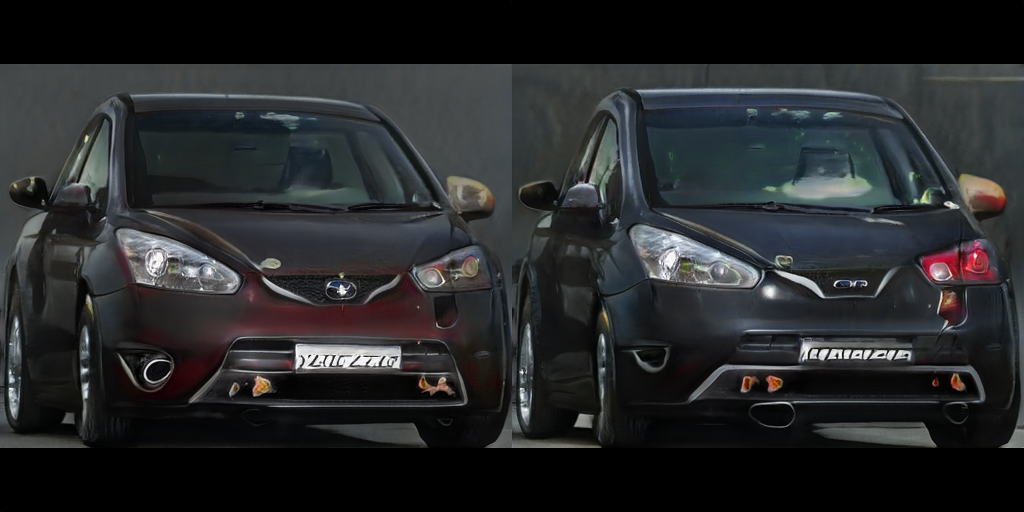

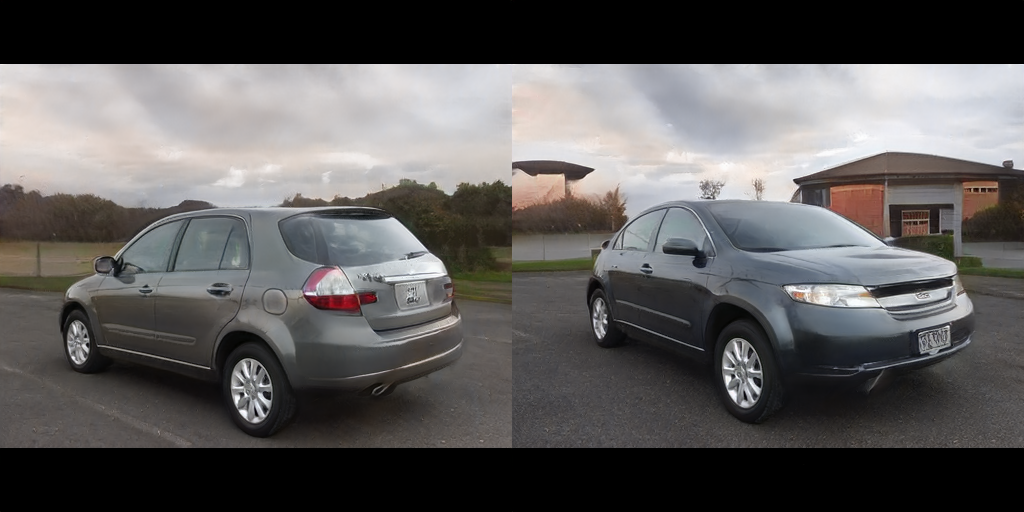

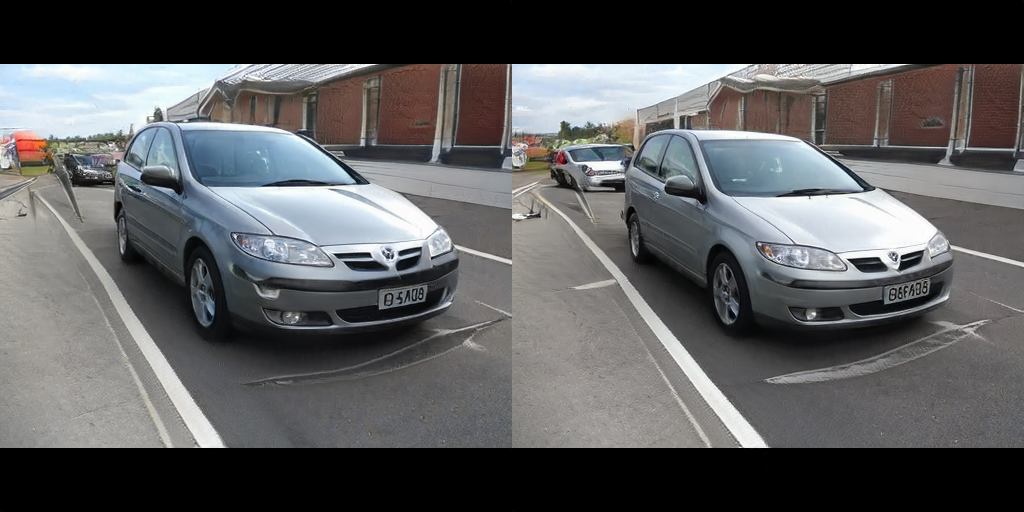

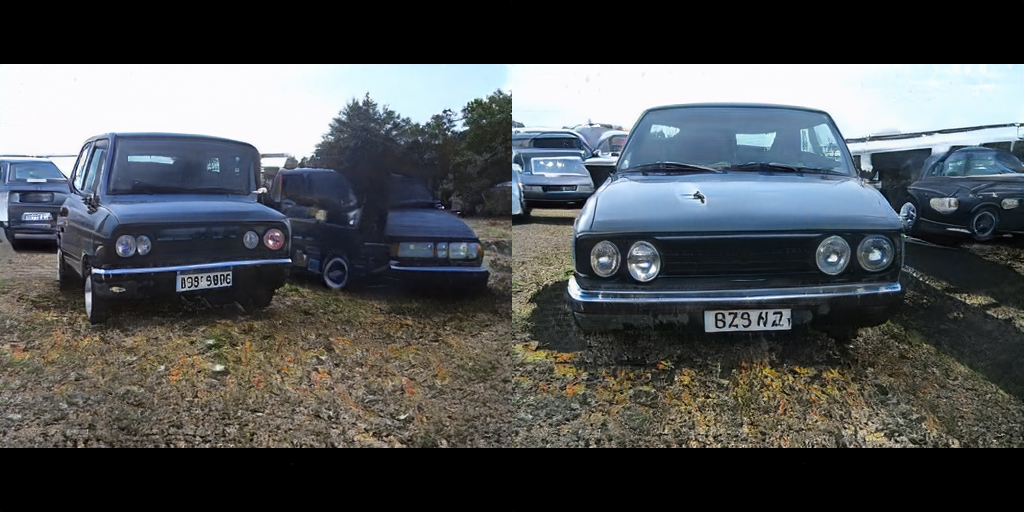

In [5]:
batch_size = 4
z_anchor = torch.tensor(np.random.normal(0.0, 1.0, [batch_size, 512]), dtype=torch.float32, requires_grad=False).to(device)
z_neighbor = torch.tensor(np.random.normal(0.0, 0.25, [batch_size, 512]), dtype=torch.float32, requires_grad=False).to(device)

with torch.no_grad():
    x_anchor = gan_model(z_anchor)
    x_neighbor = gan_model(z_anchor+z_neighbor)
for bs in range(batch_size):
    im_anchor = renormalize.as_image(x_anchor[bs])
    im_neighbor = renormalize.as_image(x_neighbor[bs])
    display(image_grid([im_anchor, im_neighbor]))

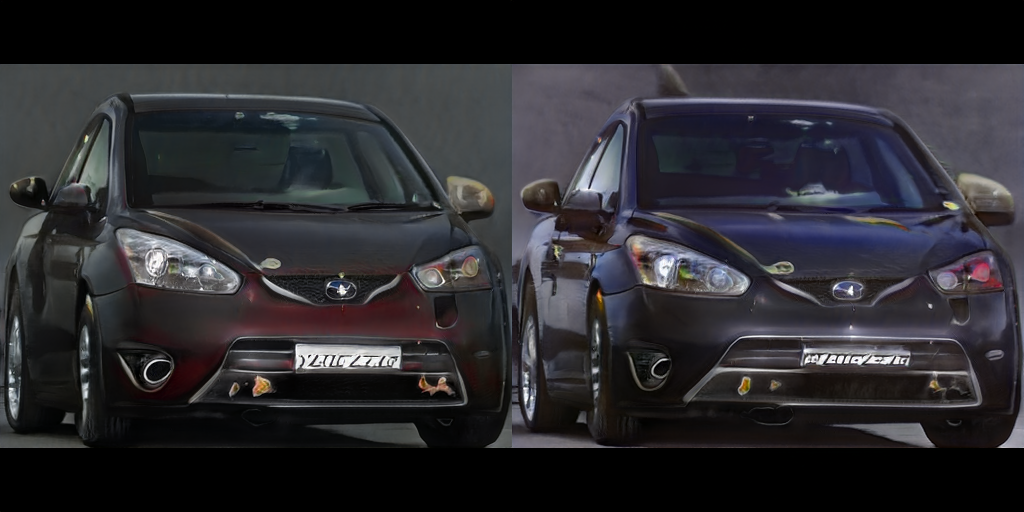

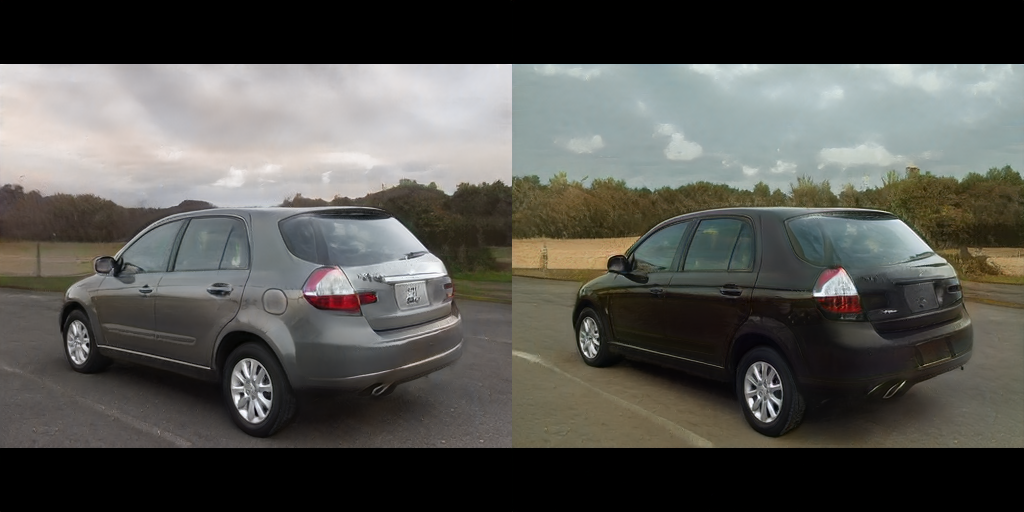

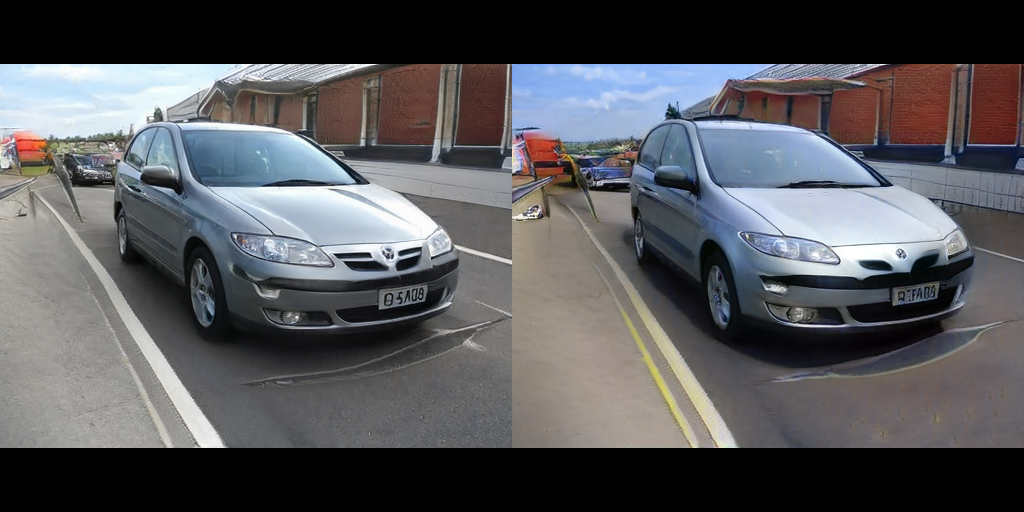

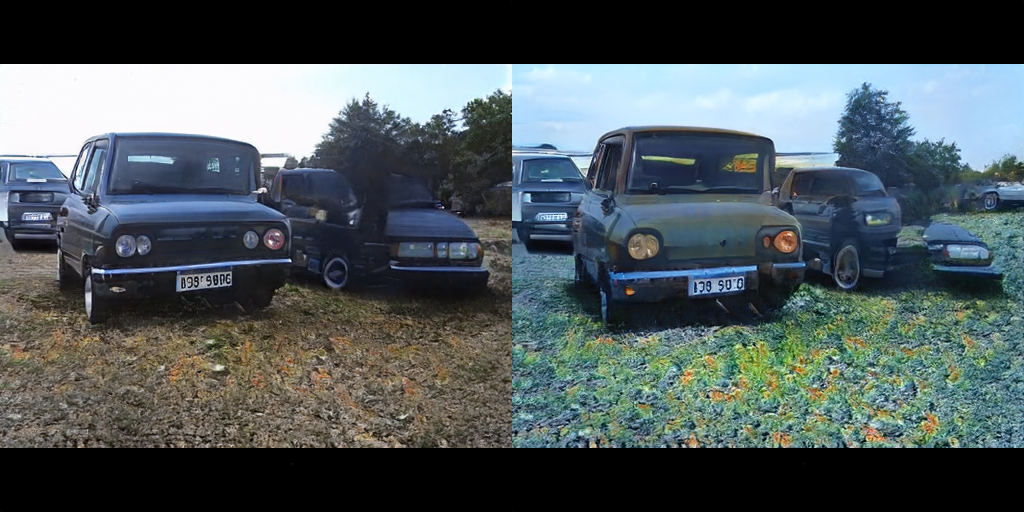

In [6]:
with torch.no_grad():
    d = compute_w(z_anchor)
    w = d.latent
    x_w_anchor = generate_from_w(DataBag(latent=w))
    w_neighbor = torch.tensor(np.random.normal(0.0, 0.6, [batch_size,16,512]), dtype=torch.float32, requires_grad=False).to(device)
    x_w_neighbor = generate_from_w(DataBag(latent=w+w_neighbor))
for bs in range(batch_size):
    im_w_anchor = renormalize.as_image(x_w_anchor[bs])
    im_w_neighbor = renormalize.as_image(x_w_neighbor[bs])
    display(image_grid([im_w_anchor, im_w_neighbor]))

In [9]:
import pickle 

In [38]:
with open('z_dataset_n01558993.pkl' ,'rb') as fid:
    z_d = pickle.load(fid)

In [39]:
z_d.keys()

dict_keys(['seed0015_sample00000_anchor.png', 'seed0015_sample00001_anchor.png', 'seed0015_sample00002_anchor.png', 'seed0015_sample00000_1.0_1.png', 'seed0015_sample00001_1.0_1.png', 'seed0015_sample00002_1.0_1.png'])

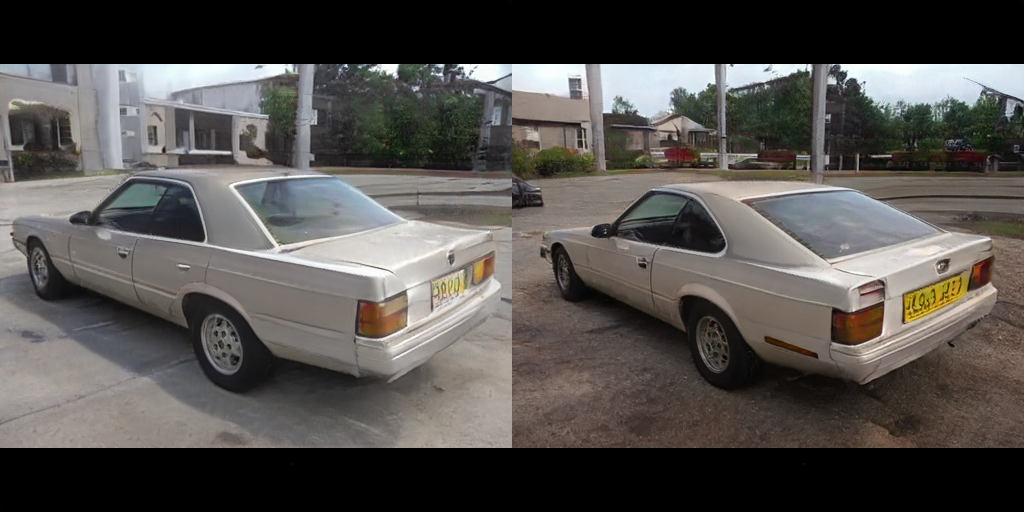

In [43]:
z_anchor = z_d['seed0015_sample00001_anchor.png'][0]
z_neighbor = z_d['seed0015_sample00001_1.0_1.png'][0]
with torch.no_grad():
    x_anchor = gan_model(torch.tensor(z_anchor.reshape(1,512)).to(device))
    x_neighbor = gan_model(torch.tensor(z_neighbor.reshape(1,512)).to(device))
for bs in range(1):
    im_anchor = renormalize.as_image(x_anchor[bs])
    im_neighbor = renormalize.as_image(x_neighbor[bs])
    display(image_grid([im_anchor, im_neighbor]))
    


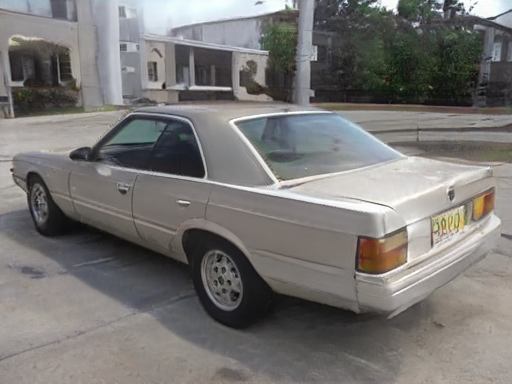

In [72]:
Image.fromarray(np.array(im_anchor)[64:448,:,:])